<a href="https://colab.research.google.com/github/janetshin8030/Sonus/blob/main/jwave_FWI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade jax[cuda12]==0.4.38 jaxlib[cuda12]==0.4.38 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install nibabel nilearn jwave tqdm

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.5.1
    Uninstall

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import jax
from nilearn import datasets
from scipy.ndimage import gaussian_filter, center_of_mass, shift, median_filter
from functools import partial
import jax.numpy as jnp
from jax import grad,random, value_and_grad, vmap, jit, lax, nn
from jax.example_libraries import optimizers
from tqdm import tqdm
from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (Domain, Medium, Sensors, Sources, TimeAxis, circ_mask, points_on_circle)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth, analytic_signal
from jaxdf.operators import compose, gradient, functional # Functional and gradient not directly used here for reconstruction
from scipy.signal import butter, sosfiltfilt as scipy_sosfiltfilt, sosfreqz



Text(0.5, 1.0, 'Axial Slice MRI Data')

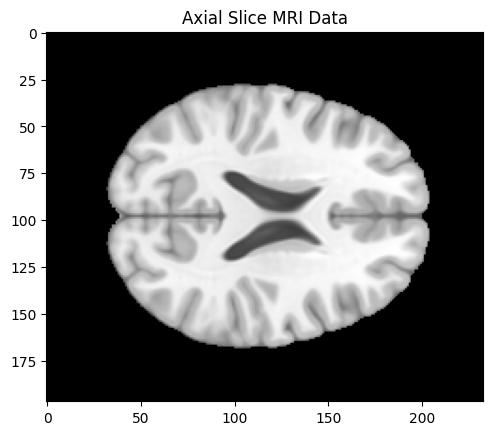

In [ ]:
# Load a sample NIfTI brain (MNI152 T1 template from nilearn)
nifti_img = datasets.load_mni152_template()
img_data = nifti_img.get_fdata() # gives you MR signal densitie
# slicing to axial slice
x, y, z = img_data.shape
axial = img_data[:, :, z // 2]

# Plot slice
plt.imshow(axial, cmap='gray')
plt.title('Axial Slice MRI Data')

(98, 116)

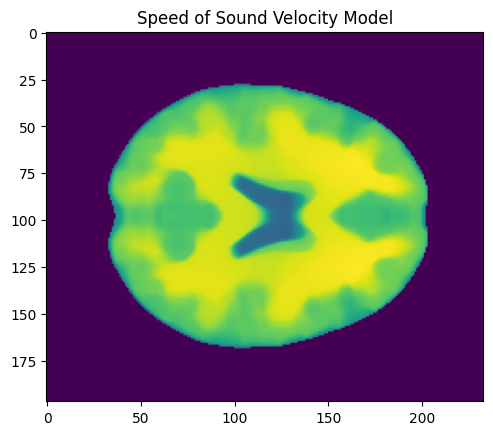

In [ ]:
def img_to_velocity_model_3d(img_data, vmin=1500, vmax=1550):
    norm = (img_data - img_data.min()) / (img_data.max() - img_data.min()) #scaling factor
    velocity = vmin + norm * (vmax - vmin)
    return velocity
# params are going to be directly velocity
uncentered_velocity_model = img_to_velocity_model_3d(axial).astype(np.float32)

N_shape = uncentered_velocity_model.shape
true_y, true_x = N_shape[0] // 2, N_shape[1] // 2
center = (true_y, true_x) # why is it flipped like this
com_y, com_x = center_of_mass(uncentered_velocity_model)
shift_y = true_y - com_y
shift_x = true_x - com_x
velocity_model_unsimplified = shift(uncentered_velocity_model, (shift_y, shift_x), order=0, cval=1500)

#simplified model
#how much it blurs
kernel_size = 15
velocity_model = median_filter(velocity_model_unsimplified, size=kernel_size)

# Save for use in JWave
np.save("velocity_model_axial.npy", velocity_model)

plt.imshow(velocity_model)
plt.title("Speed of Sound Velocity Model")
plt.show()


197

Text(0.5, 1.0, 'Source signals')

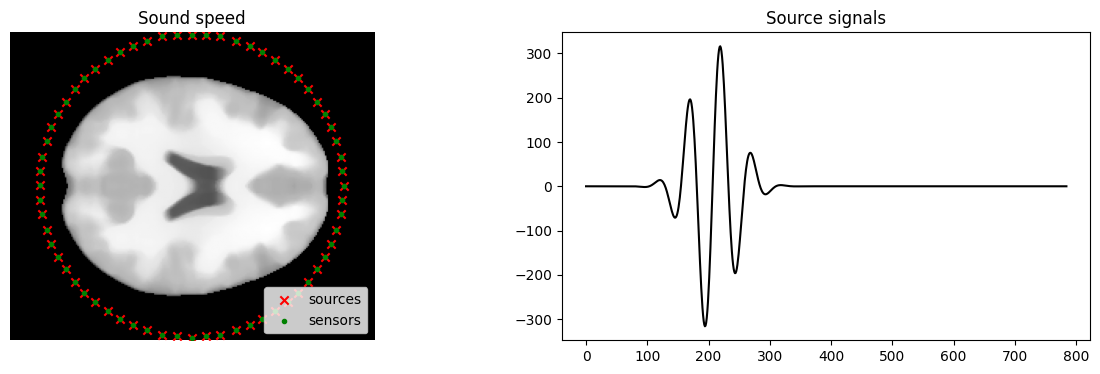

In [ ]:
# domain and medium
N          = velocity_model.shape                # (rows, cols)
dx         = (1.5e-4, 1.5e-4)                    # 0.15 mm voxel spacing
cfl        = 0.40
num_sources = 64
source_freq = 500e3
source_mag = 1.3e-5                              # continous pressure amplitude
domain      = Domain(N, dx)
sound_speed = FourierSeries(jnp.expand_dims(jnp.array(velocity_model), -1), domain) # why fourier series here
medium      = Medium(domain=domain, sound_speed=sound_speed, pml_size=20.0)
time_axis   = TimeAxis.from_medium(medium, cfl=cfl)
random_seed = random.PRNGKey(42)
radius = int(min(N) * 0.495)
center = (true_y, true_x)

# Convert continuous amplitude to per‐time‐step amplitude
source_mag  = source_mag / time_axis.dt
t = time_axis.to_array()
ideal_sine_wave = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)

num_cycles = 4
window_len = num_cycles / source_freq
sigma = window_len / 4 # what is sigma???

signal = gaussian_window(
    apply_ramp(ideal_sine_wave, time_axis.dt, source_freq),
    t,
    window_len, # This is num_cycles / f0
    sigma       # This is now window_len / 4
)
# transducers and sensors
y,x = points_on_circle(num_sources, radius=radius, centre=center)
x_i = jnp.round(jnp.array(x)).astype(jnp.int32)
y_i = jnp.round(jnp.array(y)).astype(jnp.int32)
source_positions = (jnp.array(y_i), jnp.array(x_i))
sensor_positions = (jnp.array(y_i), jnp.array(x_i))
sensors = Sensors(positions=sensor_positions)

#plotting source and transducers

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensor_positions[1], sensor_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")

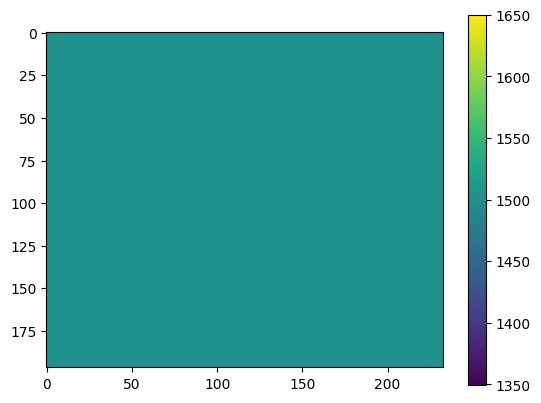

In [ ]:
from jaxdf.operators import compose

mask = circ_mask(domain.N, radius, center)
mask = FourierSeries(jnp.expand_dims(mask, -1), domain)

def reset_background(params):
  '''
  resets to every 1500 for the mask after every iteration (is there a better way to do this??? seems stupid)
  '''
  return (1500 * (1.0 - mask)) + (params * mask)

params = medium.sound_speed * 0 + 1500
plt.imshow(params.on_grid)
plt.colorbar()

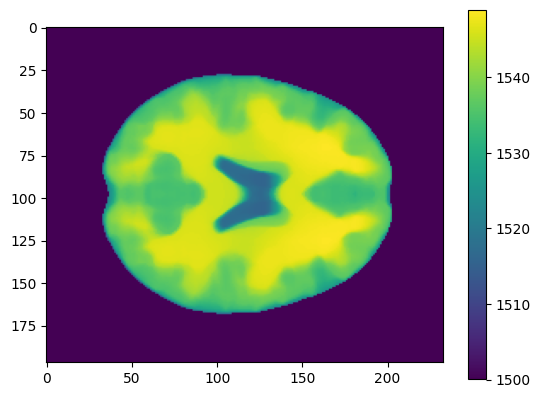

In [ ]:
plt.imshow(reset_background(medium.sound_speed).on_grid)
plt.colorbar()

In [ ]:
src_signal = jnp.stack([signal])


@jit
def single_source_simulation(sound_speed_fs, source_num_idx):
    """
    Runs a single wave propagation simulation for a given sound speed model
    and a specific source.
    `sound_speed_fs` is a FourierSeries object.
    """
    # Select the source position dynamically for jit
    x_pos = lax.dynamic_slice(source_positions[0], (source_num_idx,), (1,)) # source positions is a 3d matrix of 64 x coordinates and 64 y coordinates of sensors
    y_pos = lax.dynamic_slice(source_positions[1], (source_num_idx,), (1,))
    sources = Sources((x_pos, y_pos), src_signal, dt=time_axis.dt, domain=domain) # just sets the sources and signal??

    medium_new = Medium(domain=domain, sound_speed=sound_speed_fs, pml_size=20.0) # creating new medium, what kind of variable should sound_speed_fs be??

    # Run simulation
    rf_signals = simulate_wave_propagation(
        medium_new, time_axis, sources=sources, sensors=sensors
    )
    return rf_signals[..., 0]


In [ ]:
p_medium = single_source_simulation(medium.sound_speed, 20)
p_params = single_source_simulation(params, 20)

Array(1500., dtype=float32)

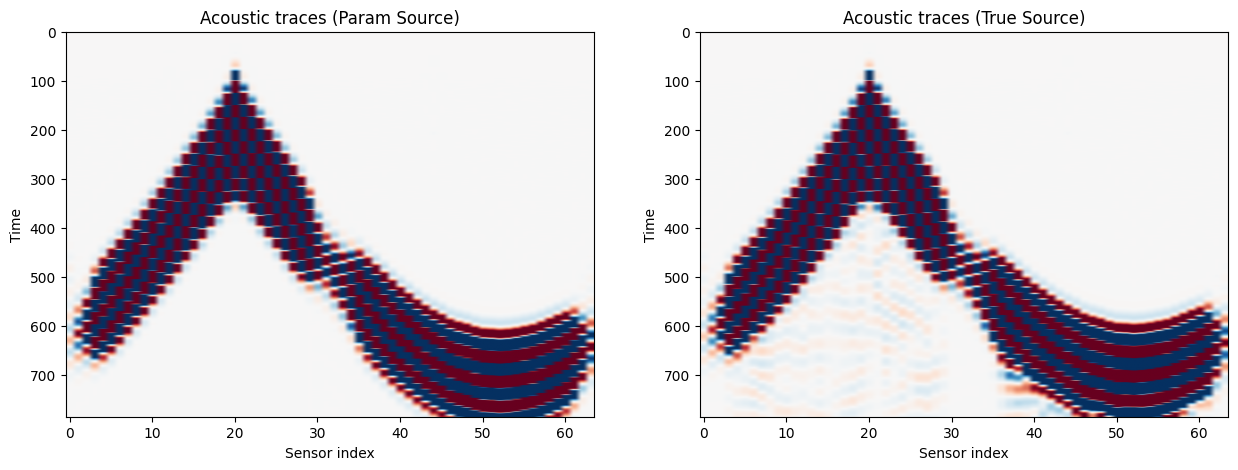

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
maxval = jnp.max(jnp.abs(p_params))
axs[0].imshow(p_params, cmap='RdBu_r', vmin=-0.1, vmax=0.1, aspect='auto')
axs[0].set_title("Acoustic traces (Param Source)")
axs[0].set_xlabel("Sensor index")
axs[0].set_ylabel("Time")

maxval = jnp.max(jnp.abs(p_medium))
axs[1].imshow(p_medium, cmap='RdBu_r', vmin=-0.1, vmax=0.1, aspect='auto')
axs[1].set_title("Acoustic traces (True Source)")
axs[1].set_xlabel("Sensor index")
axs[1].set_ylabel("Time")

plt.show()

In [ ]:
batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))

In [ ]:
def loss_func(params, source_num):
    c_current = reset_background(params)
    p = single_source_simulation(params, source_num)
    data = p_data[source_num]
    return jnp.mean(jnp.abs(p - data) ** 2)

loss_with_grad = value_and_grad(loss_func, argnums=0)
# source_num_idx = 20
# loss_init, gradient_init = loss_with_grad(
#     params,
#     source_num= source_num_idx
# )
#gmin, gmax = gradient_init.on_grid.min(), gradient_init.on_grid.max()

In [ ]:
# updating from loss
losshistory = []
reconstructions = []
num_steps = 10 # num reps of all 64 runs

# Adam optimizer setup - play around with step size
init_fun, update_fun, get_params = optimizers.adam(step_size=0.1, b1=0.9, b2=0.999, eps=1e-8) # still don't get what this opt_state does
opt_state = init_fun(params)
@jit
def update(opt_state, src_num, step):
    c_current= get_params(opt_state)
    lossval, gradient = loss_with_grad(c_current, src_num)
    return lossval, update_fun(step, gradient, opt_state)

# do all transducers (full sweep) for better convergence (and then do num_reps)
global_step_counter = 0
pbar_steps = tqdm(range(num_steps))
for step in pbar_steps:
  pbar_sources = tqdm(range(num_sources))
  for source in pbar_sources:
    global_step_counter += 1 # Increment the global step counter with each optimization update

    # Pass the source index and the global step counter for ADAM
    lossval, opt_state = update(opt_state, source, global_step_counter)

    losshistory.append(lossval) # Keep only one of these lines

    ## for logging
    new_params = get_params(opt_state)
    reconstructions.append(reset_background(new_params).on_grid) # don't know if that does anything

    # each single source
    pbar_sources.set_description(f"Optimizing for Source {source}, Loss: {lossval:.4e}")

  # each mass source
  pbar_steps.set_description(f"Processing Sources, Last Loss (Source {source}): {lossval:.4e}")

# Final parameters after all optimization
final_params = get_params(opt_state)
final_reconstruction = reset_background(final_params).on_grid


Optimizing for Source 63, Loss: 6.9296e-03: 100%|██████████| 64/64 [00:24<00:00,  2.65it/s]
Processing Sources, Last Loss (Source 63): 6.9296e-03:  10%|█         | 1/10 [00:24<03:37, 24.12s/it]
Optimizing for Source 63, Loss: 4.7096e-03: 100%|██████████| 64/64 [00:21<00:00,  2.99it/s]
Processing Sources, Last Loss (Source 63): 4.7096e-03:  20%|██        | 2/10 [00:45<03:00, 22.53s/it]
Optimizing for Source 63, Loss: 3.2339e-03: 100%|██████████| 64/64 [00:21<00:00,  2.99it/s]
Processing Sources, Last Loss (Source 63): 3.2339e-03:  30%|███       | 3/10 [01:06<02:34, 22.03s/it]
Optimizing for Source 63, Loss: 2.1422e-03: 100%|██████████| 64/64 [00:21<00:00,  2.99it/s]
Processing Sources, Last Loss (Source 63): 2.1422e-03:  40%|████      | 4/10 [01:28<02:10, 21.78s/it]
Optimizing for Source 63, Loss: 1.4851e-03: 100%|██████████| 64/64 [00:21<00:00,  2.99it/s]
Processing Sources, Last Loss (Source 63): 1.4851e-03:  50%|█████     | 5/10 [01:49<01:48, 21.65s/it]
Optimizing for Source 63, Loss

'\nbad code, why??\n\npbar_steps = tqdm(range(num_steps))\npbar_sources = tqdm(range(num_sources))\nfor source in pbar_sources:\n  for step in pbar_steps:\n    #key, subkey = random.split(random.PRNGKey(step))\n    lossval, opt_state = update(opt_state, source, step) # update_fun returns an opt state?\n    losshistory.append(lossval)\n    ## For logging\n    new_params = get_params(opt_state)\n    reconstructions.append(get_sound_speed(new_params).on_grid)\n    losshistory.append(lossval)\n    #pbar.set_description("Loss: {}".format(lossval))\n  pbar_sources.set_description("Loss: {}".format(lossval), "Source: {}".format(source))\n\n  '

In [ ]:
get_params(opt_state).on_grid.max()

Array(1500.096, dtype=float32)

Array(1500.096, dtype=float32)

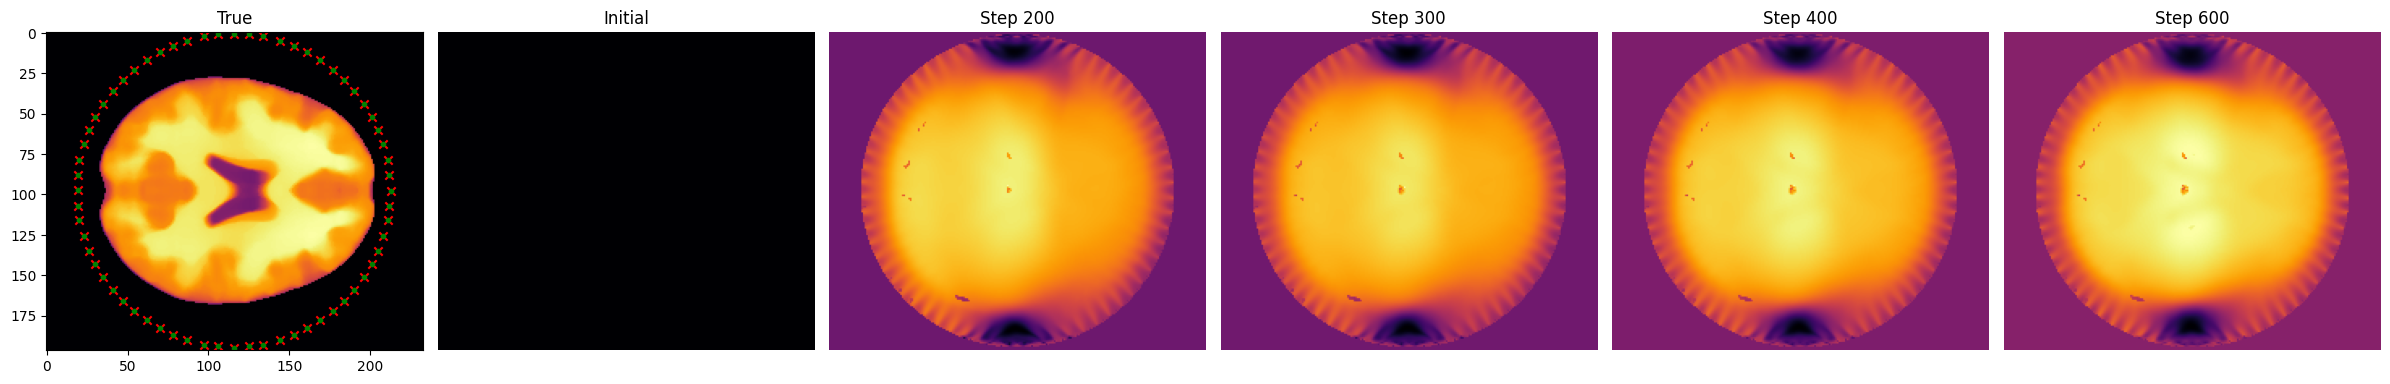

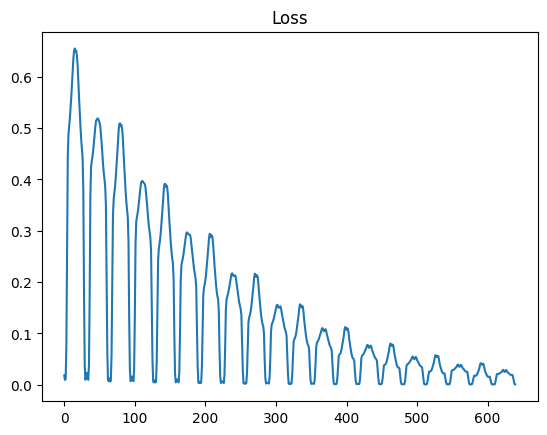

<Figure size 640x480 with 0 Axes>

In [ ]:
sos_original = reset_background(params).on_grid
true_sos = sound_speed.on_grid
vmin = np.amin(true_sos)
vmax = np.amax(true_sos)
final_params = get_params(opt_state)

true_sos  = sound_speed.on_grid[...,0]
sos_init  = params.on_grid[...,0]
sos_final = final_params.on_grid[...,0]
delta     = sos_final - sos_init
#recs= [0]
#recs = [0,4,6,9]
recs = [199, 299, 399, 599]
#recs = [0,34,44,63]
snaps= [reconstructions[i][...,0] for i in recs]

# true and initial subplots
n = len(snaps) + 2
fig, axs = plt.subplots(1, n, figsize=(4*n,4))

# fixed scale
vmin, vmax = true_sos.min(), true_sos.max()

# plot dimensions based on true model
N_plot_x, N_plot_y = true_sos.shape[1], true_sos.shape[0] # N[1] is width (x), N[0] is height (y)


# Default imshow origin is 'upper' (y-axis from top to bottom)
extent = [-0.5, N_plot_x - 0.5, N_plot_y - 0.5, -0.5] # don't know what this is
axs[0].imshow(true_sos, cmap="inferno", vmin=vmin, vmax=vmax)
axs[0].set_title("True"); #   axs[0].axis("off")
axs[0].scatter(source_positions[1], source_positions[0], c="r", marker="x", label="sources")
axs[0].scatter(sensor_positions[1], sensor_positions[0], c="g", marker=".", label="sensors")
axs[0].imshow(true_sos, cmap="inferno", vmin=vmin, vmax=vmax, extent=extent)

axs[1].imshow(sos_init, cmap="inferno", vmin=vmin, vmax=vmax)
axs[1].set_title("Initial"); axs[1].axis("off")
# recon snapshots auto-scale individually
for i, snap in enumerate(snaps):
    ax = axs[2+i]
    ax.imshow(snap, cmap="inferno")
    ax.set_title(f"Step {recs[i]+1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

plt.plot(losshistory) # change vmin and vmax
plt.title("Loss")
plt.show()


#fig.tight_layout()

plt.savefig('fwi.pdf')

Array(1500., dtype=float32)

In [ ]:
plt.imshow(reconstructions[300])

NameError: name 'plt' is not defined

In [ ]:
reconstructions[9].max()

Array(1500., dtype=float32)